In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2 as cv
savepatch2 = "/content/drive/MyDrive/yolov7/plate_img.png"
save_img = cv.imread(savepatch2,0)

In [4]:
class_names = subdirs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'ch', 'd', 'ein', 'f', 'g', 'ghaf', 'ghein', 'h2', 'hj', 'j', 'k', 'kh', 'l', 'm', 'n', 'p', 'r', 's', 'sad', 'sh', 't', 'ta', 'th', 'v', 'y', 'z', 'za', 'zad', 'zal', 'zh']
labels_nums = [i for i in range(0,len(class_names))]

In [5]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from math import sqrt, atan, degrees

In [6]:
def find_longest_line(save_img):
    kernel_size = 3
    blur_gray = cv.GaussianBlur(save_img, (kernel_size, kernel_size), 0)

    low_threshold = 150
    high_threshold = 200

    edges = cv.Canny(blur_gray, low_threshold, high_threshold)

    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50  # minimum number of pixels making up a line
    max_line_gap = 5  # maximum gap in pixels between connectable line segments
    line_image = np.copy(save_img) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    lls = []
    for indx, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
            line_length = sqrt((x2-x1)**2 + (y2-y1)**2)
            lls.append((indx,line_length))
    lls.sort(key = lambda x: x[1])
    linessorted = []
    for (indx,ll) in lls:
        linessorted.append(lines[indx])
    return linessorted

def find_line_angle(line):
    x1,y1,x2,y2 = line[0]
    angle = degrees(atan(((y2-y1)/(x2-x1))))
    return angle

def rotate_image(plate_img_gr, angle):
    (h, w) = plate_img_gr.shape
    (cX, cY) = (w // 2, h // 2)
    M = cv.getRotationMatrix2D((cX, cY), angle, 1.0)
    rotated = cv.warpAffine(plate_img_gr, M, (w, h))
    return rotated

def adjust_cropping(rotated_img):
    h,w = rotated_img.shape
    targ_h = int(w/4)
    crop_h = int((h - targ_h)/2)
    cropped_rotated_img = rotated_img[crop_h:h-crop_h,:]
    return cropped_rotated_img
# Draw the lines on the  image
#lines_edges = cv.addWeighted(plate_img, 0.8, line_image, 1, 0)

In [ ]:
linessorted = find_longest_line(save_img)
rot_angle = find_line_angle(linessorted[-1])
rotated_img = rotate_image(save_img, rot_angle)
cropped_rotated_img = adjust_cropping(rotated_img)
cw = cropped_rotated_img.shape[1]

plt.imshow(cropped_rotated_img)

In [8]:
h, w = cropped_rotated_img.shape
chopfactors = [(40,120),(100,200),(180,280),(270,360),(350,400),(400,460),(460,530),(530,600)]

In [9]:
plate_letters= []
for factor in chopfactors:
    w1 = int((factor[0]/600)*w)
    w2 = int((factor[1]/600)*w)
    letterpatch = cropped_rotated_img[:,w1:w2]
    #cv.imwrite(f"{str(factor[0])}_{str(factor[1])}.png", letterpatch)
    letterpatch_resized = cv.resize(letterpatch, (28,28), interpolation= cv.INTER_LINEAR)
    plate_letters.append(letterpatch_resized)

plate_letters = np.array(plate_letters)
plate_letters.shape

(8, 28, 28)

In [ ]:
!pip install roboflow

In [12]:
%cd /content/drive/MyDrive/yolov7

from roboflow import Roboflow
rf = Roboflow(api_key='VdwBRxsJsFmCMW94xJjd')
project = rf.workspace('object-detection-yolov5').project('plate_ocr_ir')
dataset = project.version(2).download('folder')

/content/drive/MyDrive/yolov7
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to plate_ocr_ir-2 in folder:: 100%|██████████| 9658/9658 [40:57<00:00,  3.93it/s]


In [13]:
train_path = '/content/drive/MyDrive/yolov7/plate_ocr_ir-2/train'
valid_path = '/content/drive/MyDrive/yolov7/plate_ocr_ir-2/valid'
test_path = '/content/drive/MyDrive/yolov7/plate_ocr_ir-2/test'

In [14]:
class_names = subdirs = ['0','1','2','3','4','5','6','7','8','9','a','b','ch','d','ein','f','g','ghaf','ghein','h2','hj','j','k','kh','l','m','n','p','r','s','sad','sh','t','ta','th','v','y','z','za','zad','zal','zh']
num_classes = len(class_names)

In [15]:
train_imgs = []
train_labels = []
for index, subdir in enumerate(subdirs):
  imgfolder = os.path.join(train_path , subdir)
  for imgname in os.listdir(imgfolder):
    img = cv.imread(os.path.join(imgfolder , imgname), 0)
    train_imgs.append(img)
    train_labels.append(labels_nums[index])

c = list(zip(train_imgs , train_labels))
random.shuffle(c)
train_imgs , train_labels = zip(*c)

train_images = np.array(train_imgs)
train_labels = np.array(train_labels)

In [16]:
valid_imgs = []
valid_labels = []
for index, subdir in enumerate(subdirs):
  imgfolder = os.path.join(valid_path , subdir)
  if os.path.exists(imgfolder):
    for imgname in os.listdir(imgfolder):
      img = cv.imread(os.path.join(imgfolder , imgname), 0)
      valid_imgs.append(img)
      valid_labels.append(labels_nums[index])

c = list(zip(valid_imgs , valid_labels))
random.shuffle(c)
valid_imgs , valid_labels = zip(*c)

test_images = np.array(valid_imgs)
test_labels = np.array(valid_labels)

ghein
18


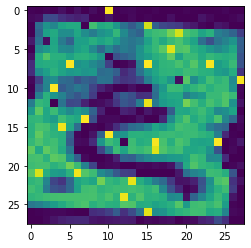

In [17]:
num = 90
print(class_names[train_labels[num]])
print(train_labels[num])
plt.imshow(train_images[num])

In [18]:
test_labels.shape

(792,)

In [19]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [33]:
import keras
modell = keras.Sequential([
    keras.layers.Flatten(input_shape = (28 , 28)),
    keras.layers.Dense(256, activation = tf.nn.relu),
    keras.layers.Dense(128, activation = tf.nn.relu),
    keras.layers.Dense(64, activation = tf.nn.relu),
    
    keras.layers.Dense(num_classes, activation = tf.nn.softmax)
])

In [34]:
modell.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
modell.fit(train_images, train_labels, epochs=100)

Epoch 1/100
261/261 [==============================] - 1s 3ms/step - loss: 3.4156 - accuracy: 0.1198
Epoch 2/100
261/261 [==============================] - 1s 3ms/step - loss: 2.5798 - accuracy: 0.3085
Epoch 3/100
261/261 [==============================] - 1s 3ms/step - loss: 2.1517 - accuracy: 0.3992
Epoch 4/100
261/261 [==============================] - 1s 3ms/step - loss: 1.9286 - accuracy: 0.4499
Epoch 5/100
261/261 [==============================] - 1s 3ms/step - loss: 1.7921 - accuracy: 0.4867
Epoch 6/100
261/261 [==============================] - 1s 3ms/step - loss: 1.6960 - accuracy: 0.5177
Epoch 7/100
261/261 [==============================] - 1s 3ms/step - loss: 1.6194 - accuracy: 0.5296
Epoch 8/100
261/261 [==============================] - 1s 3ms/step - loss: 1.5496 - accuracy: 0.5548
Epoch 9/100
261/261 [==============================] - 1s 3ms/step - loss: 1.4985 - accuracy: 0.5699
Epoch 10/100
261/261 [==============================] - 1s 3ms/step - loss: 1.4393 - accura

In [36]:
predictions = modell.predict(plate_letters)

1/1 [==============================] - 0s 105ms/step


In [37]:
[class_names[k] for k in list(np.argmax(predictions, axis=1))]

['th', '4', 'ch', '7', '4', '3', 'h2', 'ta']

In [38]:
[labels_nums[k] for k in list(np.argmax(predictions, axis=1))]

[34, 4, 12, 7, 4, 3, 19, 33]